# Using mostly pandas to explore and manipulate the data

- Explore additional customer parameters that can be extracted from the transactions
    - Average monthly withdrawal
    - Average monthly credit
    - Average monthly balance
    - Average monthly number of transactions
    - Time active with the bank
    - Average end of month balance
    - Yearly income (credit)
    - Monthly income excess (credit - withdrawal)
    
- Explore how customer spending changes with factors such as age, gender or location
- Find which data is important for building a good model to select who gets a loan
- Find the best classifier for the model and train/test it

## Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
import scipy.stats as sps
#%matplotlib notebook


from get_customer_info import get_customer_info

## Read in files and check for missing values

In [2]:
customers = pd.read_csv('seb_dc_dataset/Customer.csv')
transactions = pd.read_csv('seb_dc_dataset/Transaction.csv')
districts = pd.read_csv('seb_dc_dataset/District.csv')

#check for missing values and print column heads for reference

missing_val_count_by_column = (customers.isnull().sum())
print("Missing data from customers: ",missing_val_count_by_column[missing_val_count_by_column > 0])

missing_val_count_by_column = (transactions.isnull().sum())
print("Missing data from transactions: ",missing_val_count_by_column[missing_val_count_by_column > 0])

missing_val_count_by_column = (districts.isnull().sum())
print("Missing data from districts: ",missing_val_count_by_column[missing_val_count_by_column > 0])

Missing data from customers:  Series([], dtype: int64)
Missing data from transactions:  OPERATION    183114
dtype: int64
Missing data from districts:  Series([], dtype: int64)


## Get average customer information from transactions and add it to the dataframe

In [3]:
customers,transactions,districts = get_customer_info(customers,transactions,districts)


Average number of transactions per customer =  234.73777777777778


## Look for behaviours in spending and how this changes with customer profiles/geography

Womens average spending:  4756.392953872762
Mens average spending:  4926.121769999002
Womens average credit:  7229.759112830348
Mens average credit:  7386.02402398931
Percentage of loans to women:  51.02639296187683 %
Percentage of loans to men:  48.97360703812317 %
Womens transactions:  235.8840579710145
Mens transactions:  233.63350785340313


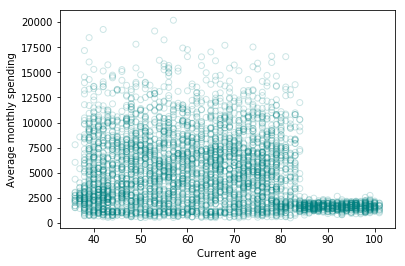

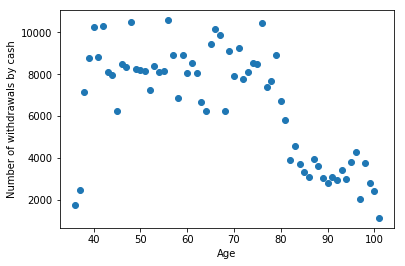

In [76]:
# Look at spending of each gender

women_spending = customers['AVG_MONTHLY_WITH'][customers['GENDER'] == 'F']
men_spending = customers['AVG_MONTHLY_WITH'][customers['GENDER'] == 'M']

women_credit = customers['AVG_MONTHLY_CRED'][customers['GENDER'] == 'F']
men_credit = customers['AVG_MONTHLY_CRED'][customers['GENDER'] == 'M']

print('Womens average spending: ',women_spending.mean())
print('Mens average spending: ',men_spending.mean())
print('Womens average credit: ',women_credit.mean())
print('Mens average credit: ',men_credit.mean())

loanlist = customers['ACCOUNT_ID'][customers['LOAN'] == 1]
nonloanlist = customers['ACCOUNT_ID'][customers['LOAN'] == 0]

women_loans = len(customers['GENDER'][(customers['ACCOUNT_ID'].isin(loanlist)) & (customers['GENDER'] == 'F')])
men_loans = len(customers['GENDER'][(customers['ACCOUNT_ID'].isin(loanlist)) & (customers['GENDER'] == 'M')])

total_loans = len(loanlist)

print('Percentage of loans to women: ',(women_loans/total_loans)*100.,'%')
print('Percentage of loans to men: ',(men_loans/total_loans)*100.,'%')


women_trans = customers['TRANSACTION_NUM'][customers['GENDER'] == 'F']
men_trans = customers['TRANSACTION_NUM'][customers['GENDER'] == 'M']

print('Womens transactions: ',women_trans.mean())
print('Mens transactions: ',men_trans.mean())

#spending based on age

plt.figure()
plt.scatter(customers['AGE'],customers['AVG_MONTHLY_WITH'],alpha=0.2,facecolors='none',edgecolors='teal')
plt.ylabel('Average monthly spending')
plt.xlabel('Current age')
plt.savefig('age_spending.png',bbox_inches='tight')

## withdrawal in cash vs age

operations = transactions.groupby(['AGE','OPERATION'],as_index=False).count()
with_cash = operations[operations['OPERATION'] == 'WITHDRAWAL_IN_CASH']

plt.figure()
plt.scatter(with_cash['AGE'],with_cash['ACCOUNT_ID'])
plt.xlabel('Age')
plt.ylabel('Number of withdrawals by cash')
plt.savefig('with_by_age.png',bbox_inches='tight')

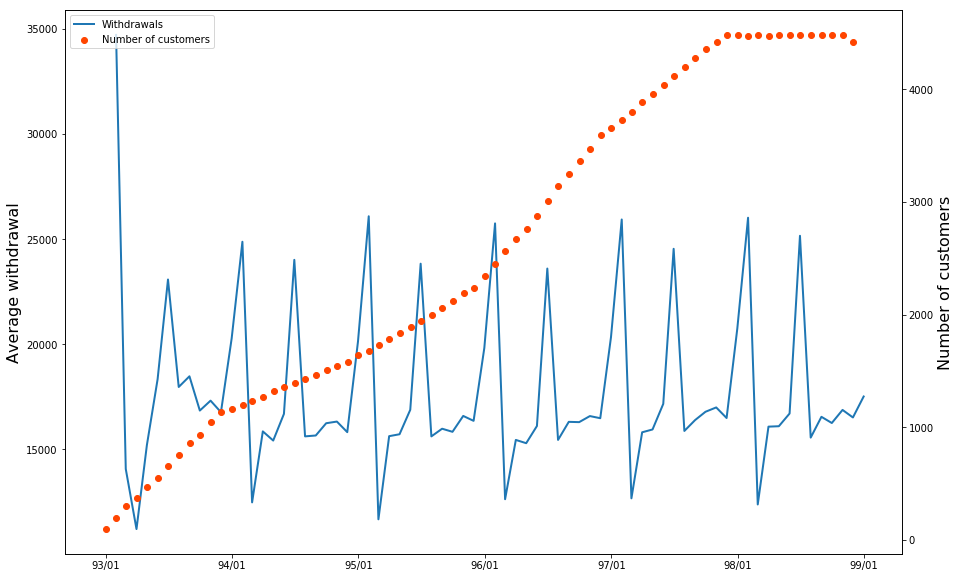

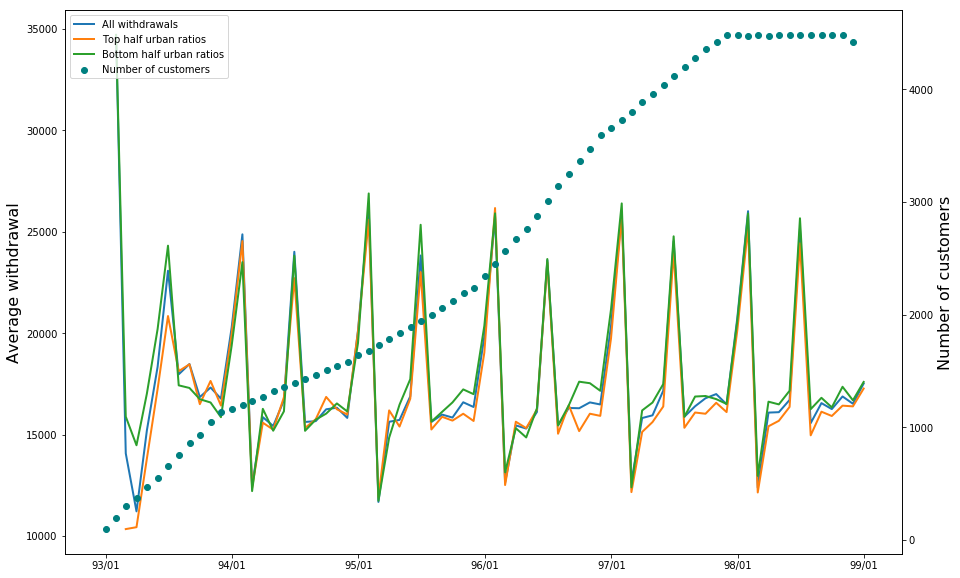

In [46]:
#calculate the average monthly spend (withdrawal) over all customers

transactions['DISTRICT_ID'] = transactions['ACCOUNT_ID'].map(customers['DISTRICT_ID'])
total_trans = transactions.groupby(['YEARMONTH','ACCOUNT_ID','TYPE','DISTRICT_ID'], as_index=False)['AMOUNT'].sum()
total_spending = total_trans[total_trans['TYPE'] == 'WITHDRAWAL']

index = pd.DatetimeIndex(total_spending['YEARMONTH'])

spending_series = pd.Series(total_spending['AMOUNT'].values, index=index)
num_trans = total_spending['YEARMONTH'].value_counts()

total_customers = transactions.groupby('YEARMONTH')['ACCOUNT_ID'].nunique()
monthly_spending = spending_series.resample("M").mean()

#set matplotlib formatting for dates

myFmt = DateFormatter("%y/%m") 

fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(111)
line = ax1.plot(monthly_spending,linewidth=2,label='Withdrawals')
ax1.set_ylabel('Average withdrawal',fontsize=16)

ax2 = ax1.twinx()
#scatter = ax2.scatter(num_trans.index,num_trans.values, color='orangered',label='Number of withdrawals')
scatter = ax2.scatter(total_customers.index,total_customers.values, color='orangered',label='Number of customers')

ax2.set_ylabel('Number of customers',fontsize=16)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=2)

ax1.xaxis.set_major_formatter(myFmt)

#select districts based on urban inhabitants

urban_districts = districts.groupby('URBAN_RATIO',as_index=False)['DISTRICT_ID'].mean()
half_districts = int(len(districts.index)/2)
non_urban = urban_districts['DISTRICT_ID'][0:half_districts]
urban = urban_districts['DISTRICT_ID'][half_districts:]

urban_total = total_trans[(total_trans['TYPE'] == 'WITHDRAWAL') & (total_trans['DISTRICT_ID'].isin(urban))]
urban_index = pd.DatetimeIndex(urban_total['YEARMONTH'])
urban_series = pd.Series(urban_total['AMOUNT'].values, index=urban_index)
urban_spending = urban_series.resample("M").mean()

nurban_total = total_trans[(total_trans['TYPE'] == 'WITHDRAWAL') & (total_trans['DISTRICT_ID'].isin(non_urban))]
nurban_index = pd.DatetimeIndex(nurban_total['YEARMONTH'])
nurban_series = pd.Series(nurban_total['AMOUNT'].values, index=nurban_index)
nurban_spending = nurban_series.resample("M").mean()


fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(111)
line = ax1.plot(monthly_spending,linewidth=2,label='All withdrawals')
line2 = ax1.plot(urban_spending,linewidth=2,label='Top half urban ratios')
line3 = ax1.plot(nurban_spending,linewidth=2,label='Bottom half urban ratios')
ax1.set_ylabel('Average withdrawal',fontsize=16)

ax2 = ax1.twinx()
scatter = ax2.scatter(total_customers.index,total_customers.values, color='teal',label='Number of customers')

ax2.set_ylabel('Number of customers',fontsize=16)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=2)

ax1.xaxis.set_major_formatter(myFmt)

plt.savefig('urban_nonurban_spending.png',bbox_inches='tight')





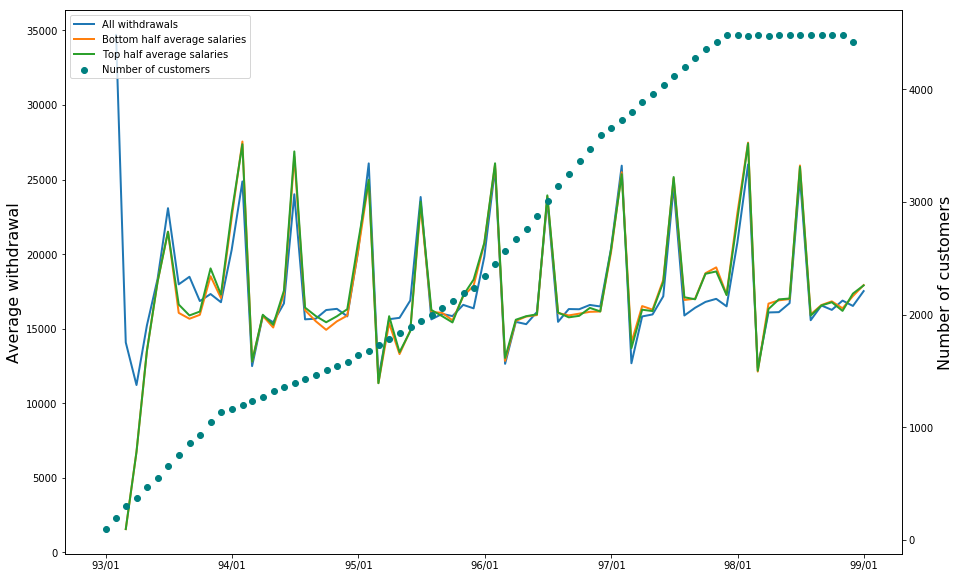

In [47]:
#select districts based on avg_salary

salary_districts = districts.groupby('AVG_SALARY',as_index=False)['DISTRICT_ID'].nunique()
half_districts = int(len(districts.index)/2)
low_salary = salary_districts[0:half_districts]
high_salary = salary_districts[half_districts:]

low_total = total_trans[(total_trans['TYPE'] == 'WITHDRAWAL') & (total_trans['DISTRICT_ID'].isin(low_salary))]
low_index = pd.DatetimeIndex(low_total['YEARMONTH'])
low_series = pd.Series(low_total['AMOUNT'].values, index=low_index)
low_spending = low_series.resample("M").mean()

high_total = total_trans[(total_trans['TYPE'] == 'WITHDRAWAL') & (total_trans['DISTRICT_ID'].isin(high_salary))]
high_index = pd.DatetimeIndex(high_total['YEARMONTH'])
high_series = pd.Series(high_total['AMOUNT'].values, index=high_index)
high_spending = high_series.resample("M").mean()

fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(111)
line = ax1.plot(monthly_spending,linewidth=2,label='All withdrawals')
line2 = ax1.plot(low_spending,linewidth=2,label='Bottom half average salaries')
line3 = ax1.plot(high_spending,linewidth=2,label='Top half average salaries')
ax1.set_ylabel('Average withdrawal',fontsize=16)

ax2 = ax1.twinx()
scatter = ax2.scatter(total_customers.index,total_customers.values, color='teal',label='Number of customers')

ax2.set_ylabel('Number of customers',fontsize=16)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=2)

ax1.xaxis.set_major_formatter(myFmt)
plt.savefig('avg_salary_spending.png',bbox_inches='tight')


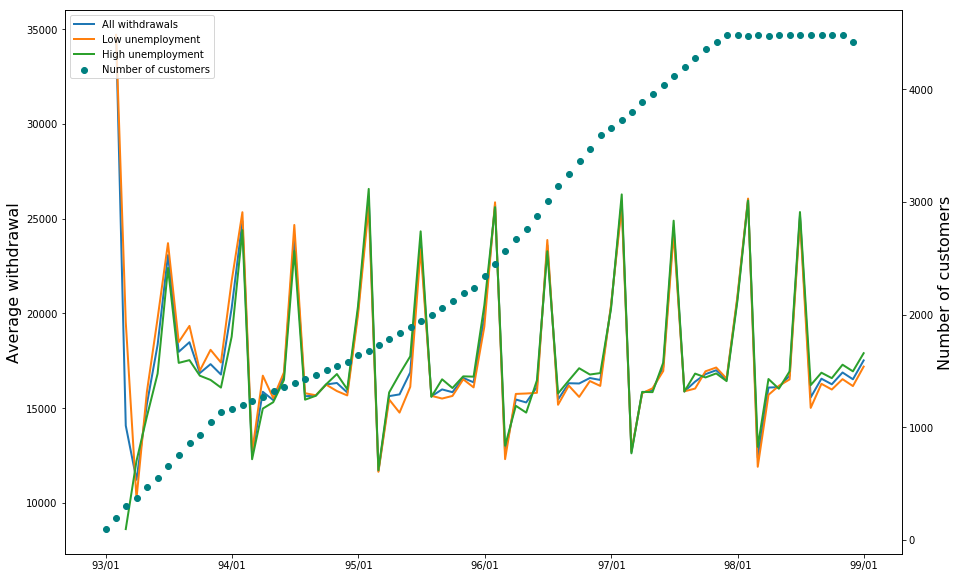

In [48]:
#select districts based on unemployment

unemp_districts = districts.sort_values('UNEMP_96')['DISTRICT_ID']
half_districts = int(len(districts.index)/2)
low_unemp = unemp_districts[0:half_districts]
high_unemp = unemp_districts[half_districts:]

low_total = total_trans[(total_trans['TYPE'] == 'WITHDRAWAL') & (total_trans['DISTRICT_ID'].isin(low_unemp))]
low_index = pd.DatetimeIndex(low_total['YEARMONTH'])
low_series = pd.Series(low_total['AMOUNT'].values, index=low_index)
low_spending = low_series.resample("M").mean()

high_total = total_trans[(total_trans['TYPE'] == 'WITHDRAWAL') & (total_trans['DISTRICT_ID'].isin(high_unemp))]
high_index = pd.DatetimeIndex(high_total['YEARMONTH'])
high_series = pd.Series(high_total['AMOUNT'].values, index=high_index)
high_spending = high_series.resample("M").mean()

fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(111)
line = ax1.plot(monthly_spending,linewidth=2,label='All withdrawals')
line2 = ax1.plot(low_spending,linewidth=2,label='Low unemployment')
line3 = ax1.plot(high_spending,linewidth=2,label='High unemployment')
ax1.set_ylabel('Average withdrawal',fontsize=16)

ax2 = ax1.twinx()
scatter = ax2.scatter(total_customers.index,total_customers.values, color='teal',label='Number of customers')

ax2.set_ylabel('Number of customers',fontsize=16)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=2)

ax1.xaxis.set_major_formatter(myFmt)
plt.savefig('employment_spending.png',bbox_inches='tight')

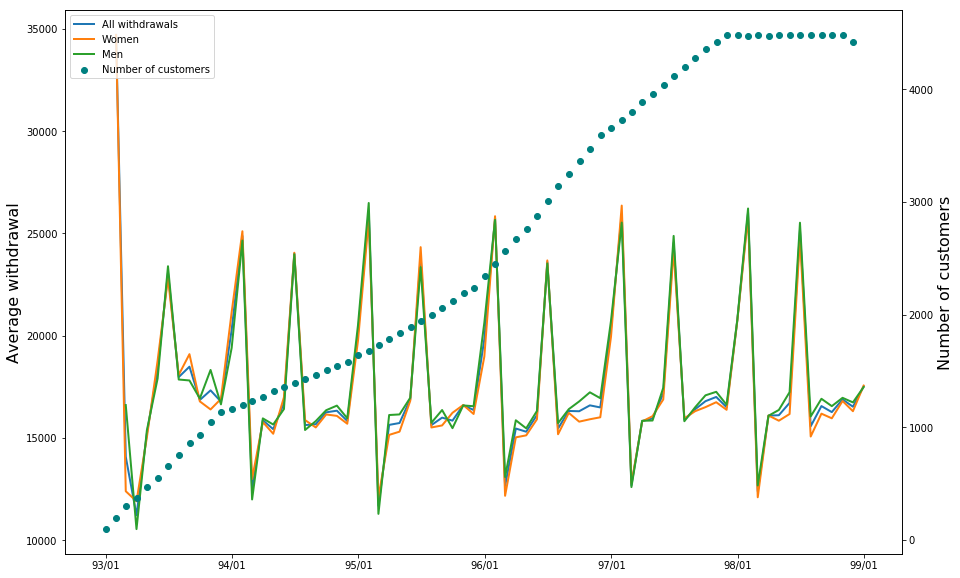

In [49]:
#look at spending based on gender

transactions['GENDER'] = transactions['ACCOUNT_ID'].map(customers['GENDER'])

total_trans = transactions.groupby(['YEARMONTH','ACCOUNT_ID','TYPE','GENDER'], as_index=False)['AMOUNT'].sum()

women_total = total_trans[(total_trans['TYPE'] == 'WITHDRAWAL') & (total_trans['GENDER'] == 'F')]
women_index = pd.DatetimeIndex(women_total['YEARMONTH'])
women_series = pd.Series(women_total['AMOUNT'].values, index=women_index)
women_spending = women_series.resample("M").mean()

men_total = total_trans[(total_trans['TYPE'] == 'WITHDRAWAL') & (total_trans['GENDER'] == 'M')]
men_index = pd.DatetimeIndex(men_total['YEARMONTH'])
men_series = pd.Series(men_total['AMOUNT'].values, index=men_index)
men_spending = men_series.resample("M").mean()

fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(111)
line = ax1.plot(monthly_spending,linewidth=2,label='All withdrawals')
line2 = ax1.plot(women_spending,linewidth=2,label='Women')
line3 = ax1.plot(men_spending,linewidth=2,label='Men')
ax1.set_ylabel('Average withdrawal',fontsize=16)

ax2 = ax1.twinx()
scatter = ax2.scatter(total_customers.index,total_customers.values, color='teal',label='Number of customers')

ax2.set_ylabel('Number of customers',fontsize=16)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=2)

ax1.xaxis.set_major_formatter(myFmt)
plt.savefig('gender_spending.png',bbox_inches='tight')

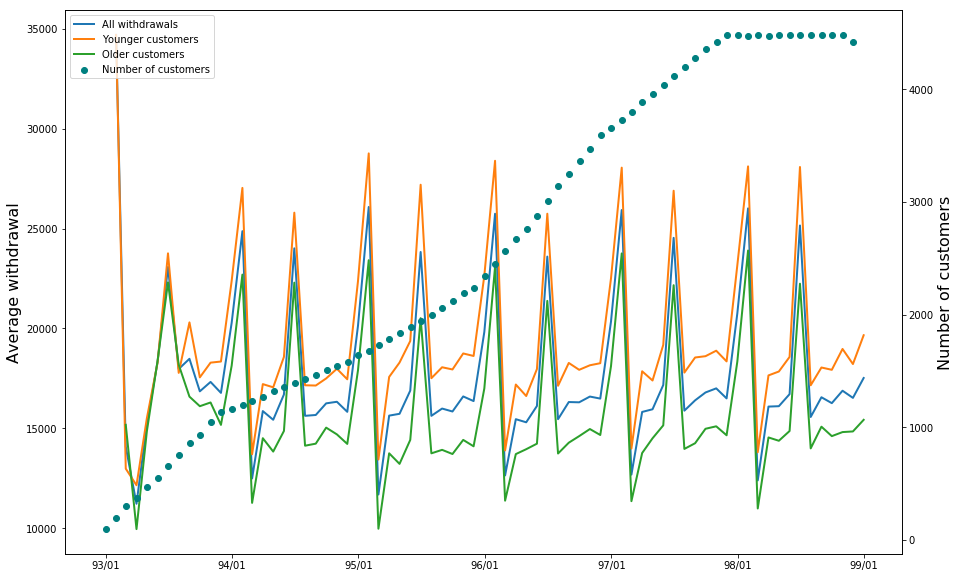

In [50]:
#look at spending based on age

transactions['AGE'] = transactions['ACCOUNT_ID'].map(customers['AGE'])

total_trans = transactions.groupby(['YEARMONTH','ACCOUNT_ID','TYPE','AGE'], as_index=False)['AMOUNT'].sum()

ages = customers.sort_values('AGE')['ACCOUNT_ID']

half_ages = int(len(customers.index)/2)
young = ages[0:half_ages]
old = ages[half_ages:]

young_total = total_trans[(total_trans['TYPE'] == 'WITHDRAWAL') & (total_trans['ACCOUNT_ID'].isin(young))]
young_index = pd.DatetimeIndex(young_total['YEARMONTH'])
young_series = pd.Series(young_total['AMOUNT'].values, index=young_index)
young_spending = young_series.resample("M").mean()

old_total = total_trans[(total_trans['TYPE'] == 'WITHDRAWAL') & (total_trans['ACCOUNT_ID'].isin(old))]
old_index = pd.DatetimeIndex(old_total['YEARMONTH'])
old_series = pd.Series(old_total['AMOUNT'].values, index=old_index)
old_spending = old_series.resample("M").mean()

fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(111)
line = ax1.plot(monthly_spending,linewidth=2,label='All withdrawals')
line2 = ax1.plot(young_spending,linewidth=2,label='Younger customers')
line3 = ax1.plot(old_spending,linewidth=2,label='Older customers')
ax1.set_ylabel('Average withdrawal',fontsize=16)

ax2 = ax1.twinx()
scatter = ax2.scatter(total_customers.index,total_customers.values, color='teal',label='Number of customers')

ax2.set_ylabel('Number of customers',fontsize=16)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc=2)

ax1.xaxis.set_major_formatter(myFmt)
plt.savefig('age_spending_monthly.png',bbox_inches='tight')

## Look at the possible factors for loan classification modelling

<Figure size 432x288 with 0 Axes>

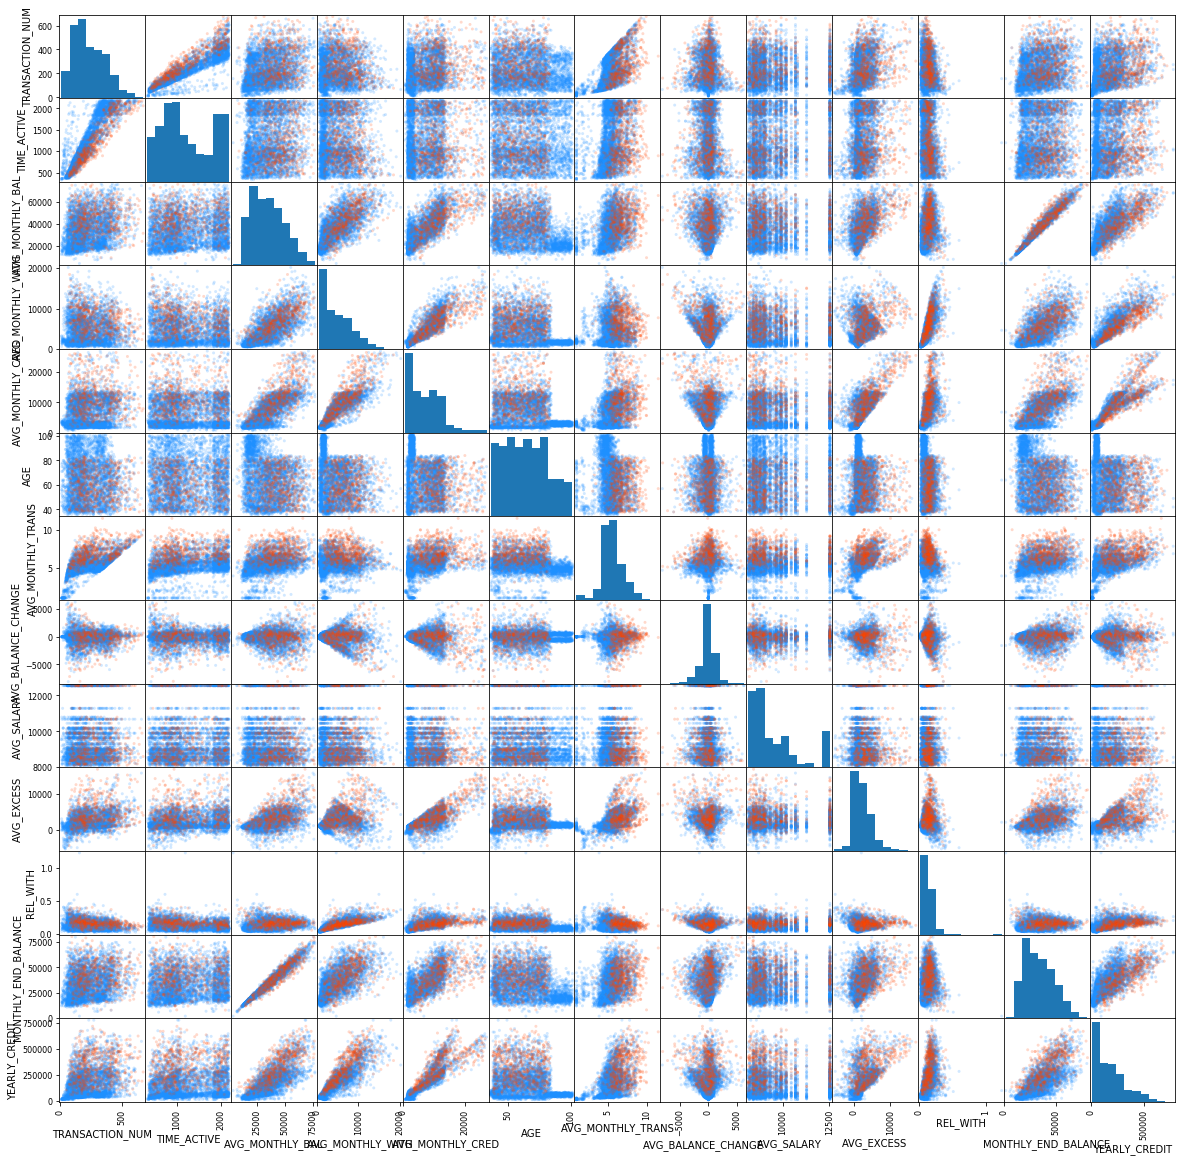

In [52]:

columns = ['TRANSACTION_NUM','TIME_ACTIVE','AVG_MONTHLY_BAL','AVG_MONTHLY_WITH','AVG_MONTHLY_CRED','AGE',
           'AVG_MONTHLY_TRANS','AVG_BALANCE_CHANGE','AVG_SALARY','AVG_EXCESS','REL_WITH','MONTHLY_END_BALANCE','YEARLY_CREDIT']

plt.figure()
plots = pd.plotting.scatter_matrix(customers[columns], color=['dodgerblue' if i == 0 else 'orangered' for i in customers['LOAN']], alpha=0.2,figsize=(20, 20), diagonal='hist')
plt.savefig('allthequantities.png',bbox_inches='tight')

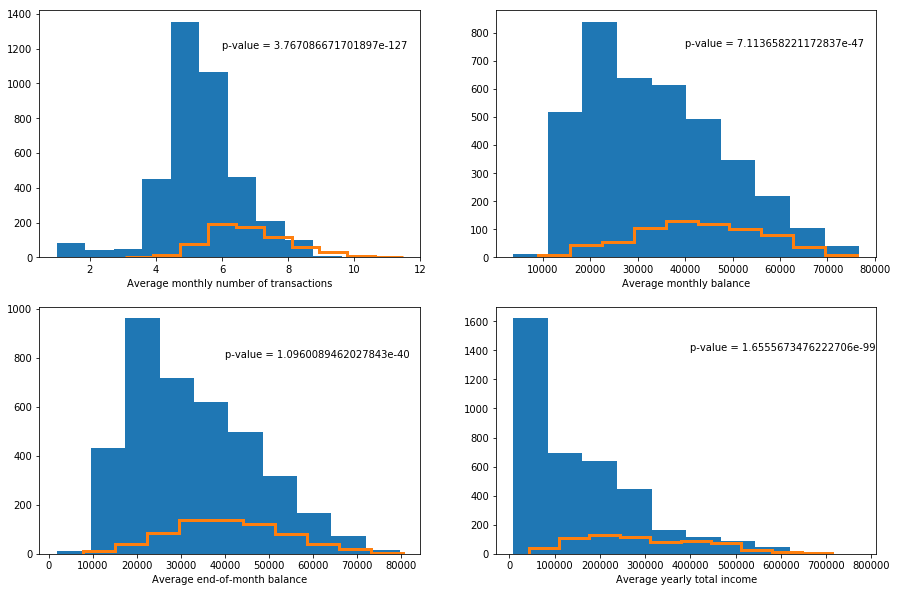

In [53]:


#look at histograms of the potential factors

plt.figure(figsize=[15,10])
plt.subplot(2,2,1)
plt.hist(customers['AVG_MONTHLY_TRANS'][customers['ACCOUNT_ID'].isin(nonloanlist)])
plt.hist(customers['AVG_MONTHLY_TRANS'][customers['ACCOUNT_ID'].isin(loanlist)],histtype='step',linewidth=3)
plt.xlabel('Average monthly number of transactions')

ks = sps.ks_2samp(customers['AVG_MONTHLY_TRANS'][customers['ACCOUNT_ID'].isin(loanlist)],
             customers['AVG_MONTHLY_TRANS'][customers['ACCOUNT_ID'].isin(nonloanlist)])

plt.text(6,1200,'p-value = '+str(ks[1]))

plt.subplot(2,2,2)
plt.hist(customers['AVG_MONTHLY_BAL'][customers['ACCOUNT_ID'].isin(nonloanlist)])
plt.hist(customers['AVG_MONTHLY_BAL'][customers['ACCOUNT_ID'].isin(loanlist)],histtype='step',linewidth=3)
plt.xlabel('Average monthly balance')

ks = sps.ks_2samp(customers['AVG_MONTHLY_BAL'][customers['ACCOUNT_ID'].isin(loanlist)],
             customers['AVG_MONTHLY_BAL'][customers['ACCOUNT_ID'].isin(nonloanlist)])

plt.text(40000,750,'p-value = '+str(ks[1]))

plt.subplot(2,2,3)
plt.hist(customers['MONTHLY_END_BALANCE'][customers['ACCOUNT_ID'].isin(nonloanlist)])
plt.hist(customers['MONTHLY_END_BALANCE'][customers['ACCOUNT_ID'].isin(loanlist)],histtype='step',linewidth=3)
plt.xlabel('Average end-of-month balance')

ks = sps.ks_2samp(customers['MONTHLY_END_BALANCE'][customers['ACCOUNT_ID'].isin(loanlist)],
             customers['MONTHLY_END_BALANCE'][customers['ACCOUNT_ID'].isin(nonloanlist)])

plt.text(40000,800,'p-value = '+str(ks[1]))

plt.subplot(2,2,4)
plt.hist(customers['YEARLY_CREDIT'][customers['ACCOUNT_ID'].isin(nonloanlist)])
plt.hist(customers['YEARLY_CREDIT'][customers['ACCOUNT_ID'].isin(loanlist)],histtype='step',linewidth=3)
plt.xlabel('Average yearly total income')

ks = sps.ks_2samp(customers['YEARLY_CREDIT'][customers['ACCOUNT_ID'].isin(loanlist)],
             customers['YEARLY_CREDIT'][customers['ACCOUNT_ID'].isin(nonloanlist)])

plt.text(400000,1400,'p-value = '+str(ks[1]))

plt.savefig('interesting_quantities.png',bbox_inches='tight')



## Attempting a machine learning model - best found with support vector classification - testing on train data first

0.8633712857539573
0.8483754512635379
0.860316578728131
0.8500416550958068
0.8597611774507081


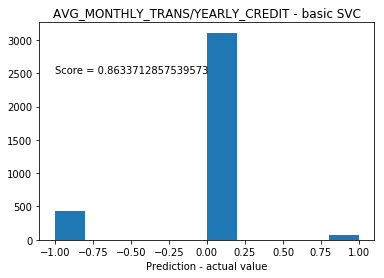

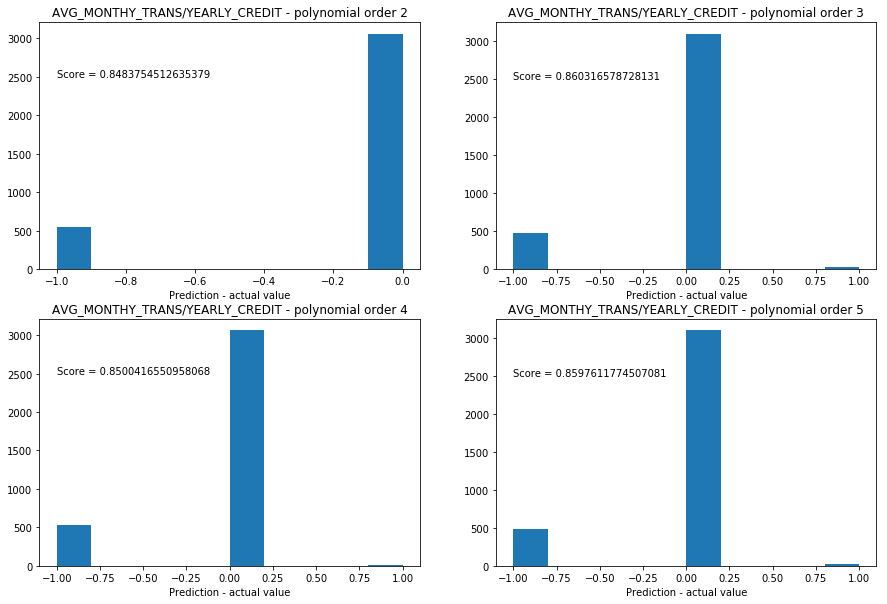

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn import svm

scaler = StandardScaler()
columns = ['AVG_MONTHLY_TRANS','YEARLY_CREDIT']

train = customers[columns][customers['SET_SPLIT'] == 'TRAIN']
test = customers[columns][customers['SET_SPLIT'] == 'TEST']

sctrain = scaler.fit(train)
sctrain = scaler.transform(train)
sctest = scaler.transform(test)

y = customers['LOAN'][customers['SET_SPLIT'] == 'TRAIN']
val_y = customers['LOAN'][customers['SET_SPLIT'] == 'TEST']

fitter = svm.SVC()
fitter.fit(sctrain,y)
results= fitter.predict(sctrain)

plt.figure()
plt.hist(results-y)
plt.xlabel('Prediction - actual value')
plt.title('AVG_MONTHLY_TRANS/YEARLY_CREDIT - basic SVC')

print(fitter.score(sctrain,y))

plt.text(-1,2500,'Score = '+str(fitter.score(sctrain,y)))

plt.savefig('basic_svc.png',bbox_inches='tight')

#try different columns

columns = ['AVG_MONTHLY_TRANS','YEARLY_CREDIT']

train = customers[columns][customers['SET_SPLIT'] == 'TRAIN']
test = customers[columns][customers['SET_SPLIT'] == 'TEST']

sctrain = scaler.fit(train)
sctrain = scaler.transform(train)
sctest = scaler.transform(test)

y = customers['LOAN'][customers['SET_SPLIT'] == 'TRAIN']
val_y = customers['LOAN'][customers['SET_SPLIT'] == 'TEST']

plt.figure(figsize=[15,10])
plt.subplot(2,2,1)
fitter = svm.SVC(kernel='poly', degree=2)
fitter.fit(sctrain,y)
results= fitter.predict(sctrain)

plt.hist(results-y)
plt.xlabel('Prediction - actual value')
plt.title('AVG_MONTHY_TRANS/YEARLY_CREDIT - polynomial order 2')

print(fitter.score(sctrain,y))

plt.text(-1,2500,'Score = '+str(fitter.score(sctrain,y)))

plt.subplot(2,2,2)
fitter = svm.SVC(kernel='poly', degree=3)
fitter.fit(sctrain,y)
results= fitter.predict(sctrain)

plt.hist(results-y)
plt.xlabel('Prediction - actual value')
plt.title('AVG_MONTHY_TRANS/YEARLY_CREDIT - polynomial order 3')

print(fitter.score(sctrain,y))

plt.text(-1,2500,'Score = '+str(fitter.score(sctrain,y)))

plt.subplot(2,2,3)
fitter = svm.SVC(kernel='poly', degree=4)
fitter.fit(sctrain,y)
results= fitter.predict(sctrain)

plt.hist(results-y)
plt.xlabel('Prediction - actual value')
plt.title('AVG_MONTHY_TRANS/YEARLY_CREDIT - polynomial order 4')

print(fitter.score(sctrain,y))

plt.text(-1,2500,'Score = '+str(fitter.score(sctrain,y)))

plt.subplot(2,2,4)
fitter = svm.SVC(kernel='poly', degree=5)
fitter.fit(sctrain,y)
results= fitter.predict(sctrain)

plt.hist(results-y)
plt.xlabel('Prediction - actual value')
plt.title('AVG_MONTHY_TRANS/YEARLY_CREDIT - polynomial order 5')

print(fitter.score(sctrain,y))

plt.text(-1,2500,'Score = '+str(fitter.score(sctrain,y)))

plt.savefig('polynomial_svc.png',bbox_inches='tight')


0.84872080089
0.846496106785
0.843159065628
0.84872080089


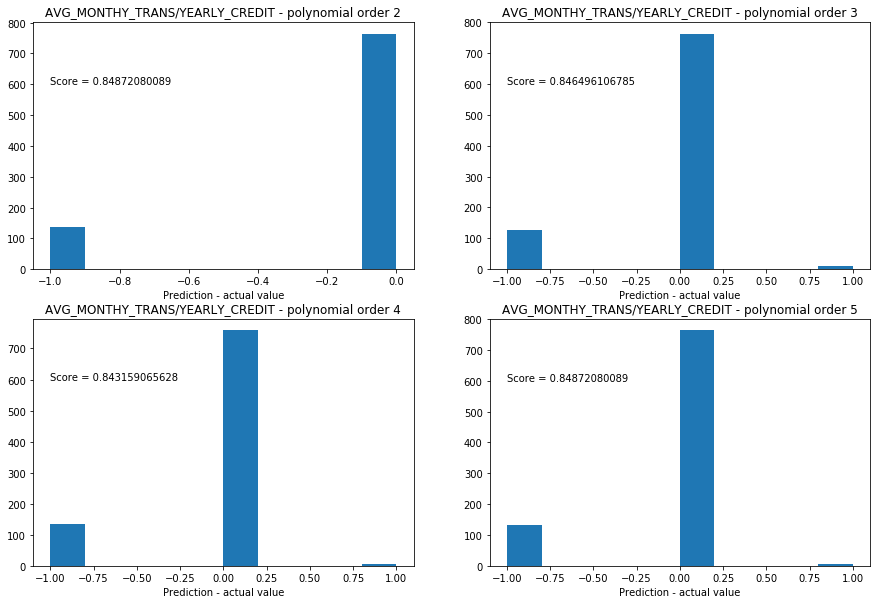

In [33]:
#predict on test data

plt.figure(figsize=[15,10])
plt.subplot(2,2,1)
fitter = svm.SVC(kernel='poly', degree=2)
fitter.fit(sctrain,y)
results= fitter.predict(sctest)

plt.hist(results-val_y)
plt.xlabel('Prediction - actual value')
plt.title('AVG_MONTHY_TRANS/YEARLY_CREDIT - polynomial order 2')

print(fitter.score(sctest,val_y))

plt.text(-1,600,'Score = '+str(fitter.score(sctest,val_y)))

plt.subplot(2,2,2)
fitter = svm.SVC(kernel='poly', degree=3)
fitter.fit(sctrain,y)
results= fitter.predict(sctest)

plt.hist(results-val_y)
plt.xlabel('Prediction - actual value')
plt.title('AVG_MONTHY_TRANS/YEARLY_CREDIT - polynomial order 3')

print(fitter.score(sctest,val_y))

plt.text(-1,600,'Score = '+str(fitter.score(sctest,val_y)))

plt.subplot(2,2,3)
fitter = svm.SVC(kernel='poly', degree=4)
fitter.fit(sctrain,y)
results= fitter.predict(sctest)

plt.hist(results-val_y)
plt.xlabel('Prediction - actual value')
plt.title('AVG_MONTHY_TRANS/YEARLY_CREDIT - polynomial order 4')

print(fitter.score(sctest,val_y))

plt.text(-1,600,'Score = '+str(fitter.score(sctest,val_y)))

plt.subplot(2,2,4)
fitter = svm.SVC(kernel='poly', degree=5)
fitter.fit(sctrain,y)
results= fitter.predict(sctest)

plt.hist(results-val_y)
plt.xlabel('Prediction - actual value')
plt.title('AVG_MONTHY_TRANS/YEARLY_CREDIT - polynomial order 5')

print(fitter.score(sctest,val_y))

plt.text(-1,600,'Score = '+str(fitter.score(sctest,val_y)))

plt.savefig('polynomial_svc_test.png',bbox_inches='tight')

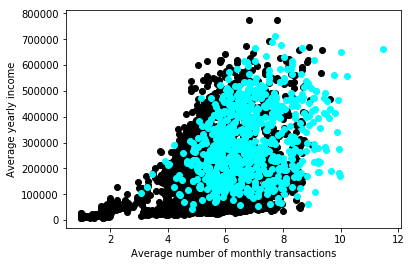

In [60]:
plt.figure()
plt.scatter(customers['AVG_MONTHLY_TRANS'][customers['ACCOUNT_ID'].isin(nonloanlist)],
            customers['YEARLY_CREDIT'][customers['ACCOUNT_ID'].isin(nonloanlist)],label='Non-loan',color='black')
plt.scatter(customers['AVG_MONTHLY_TRANS'][customers['ACCOUNT_ID'].isin(loanlist)],
            customers['YEARLY_CREDIT'][customers['ACCOUNT_ID'].isin(loanlist)],label='Loan',color='cyan')
plt.xlabel('Average number of monthly transactions')
plt.ylabel('Average yearly income')

plt.savefig('yrcred-trans.png',bbox_inches='tight')


## Investigate how the polynomial selects areas

In [61]:
def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [62]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


/home/kathh/anaconda2/envs/newpy/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kathh/anaconda2/envs/newpy/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kathh/anaconda2/envs/newpy/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/kathh/anaconda2/env

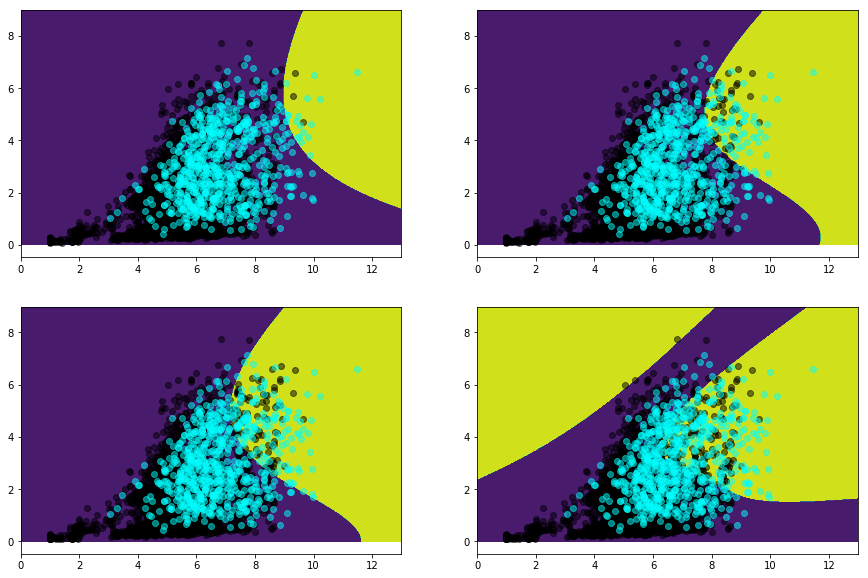

In [77]:
#self scaled data for overplotting

train = customers[columns][customers['SET_SPLIT'] == 'TRAIN']
train['YEARLY_CREDIT'] = train['YEARLY_CREDIT'] / 100000

xx, yy = np.meshgrid(np.arange(0,12+1, 0.02), np.arange(0,8 + 1,0.02))

classifier = svm.SVC(kernel='poly', degree=2)

classifier.fit(train, y)

fig = plt.figure(figsize=[15,10])

plt.subplot(2,2,1)
ax = plt.gca()
out = plot_contours(ax, classifier, xx, yy)

plt.scatter(customers['AVG_MONTHLY_TRANS'][customers['ACCOUNT_ID'].isin(nonloanlist)],
            customers['YEARLY_CREDIT'][customers['ACCOUNT_ID'].isin(nonloanlist)]/100000, alpha=0.5,color='black')
plt.scatter(customers['AVG_MONTHLY_TRANS'][customers['ACCOUNT_ID'].isin(loanlist)],
            customers['YEARLY_CREDIT'][customers['ACCOUNT_ID'].isin(loanlist)]/100000, alpha=0.5,color='cyan')

classifier = svm.SVC(kernel='poly', degree=3)

classifier.fit(train, y)

plt.subplot(2,2,2)
ax2 = plt.gca()
out = plot_contours(ax2, classifier, xx, yy)

plt.scatter(customers['AVG_MONTHLY_TRANS'][customers['ACCOUNT_ID'].isin(nonloanlist)],
            customers['YEARLY_CREDIT'][customers['ACCOUNT_ID'].isin(nonloanlist)]/100000, alpha=0.5,color='black')
plt.scatter(customers['AVG_MONTHLY_TRANS'][customers['ACCOUNT_ID'].isin(loanlist)],
            customers['YEARLY_CREDIT'][customers['ACCOUNT_ID'].isin(loanlist)]/100000, alpha=0.5,color='cyan')

classifier = svm.SVC(kernel='poly', degree=4)

classifier.fit(train, y)


plt.subplot(2,2,3)
ax3 = plt.gca()
out = plot_contours(ax3, classifier, xx, yy)

plt.scatter(customers['AVG_MONTHLY_TRANS'][customers['ACCOUNT_ID'].isin(nonloanlist)],
            customers['YEARLY_CREDIT'][customers['ACCOUNT_ID'].isin(nonloanlist)]/100000, alpha=0.5,color='black')
plt.scatter(customers['AVG_MONTHLY_TRANS'][customers['ACCOUNT_ID'].isin(loanlist)],
            customers['YEARLY_CREDIT'][customers['ACCOUNT_ID'].isin(loanlist)]/100000, alpha=0.5,color='cyan')

classifier = svm.SVC(kernel='poly', degree=5)

classifier.fit(train, y)


plt.subplot(2,2,4)
ax4 = plt.gca()
out = plot_contours(ax4, classifier, xx, yy)

plt.scatter(customers['AVG_MONTHLY_TRANS'][customers['ACCOUNT_ID'].isin(nonloanlist)],
            customers['YEARLY_CREDIT'][customers['ACCOUNT_ID'].isin(nonloanlist)]/100000, alpha=0.5,color='black')
plt.scatter(customers['AVG_MONTHLY_TRANS'][customers['ACCOUNT_ID'].isin(loanlist)],
            customers['YEARLY_CREDIT'][customers['ACCOUNT_ID'].isin(loanlist)]/100000, alpha=0.5,color='cyan')






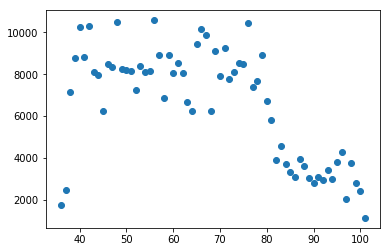